DataFrame shape: (1, 1)
Image data type: <class 'numpy.ndarray'>


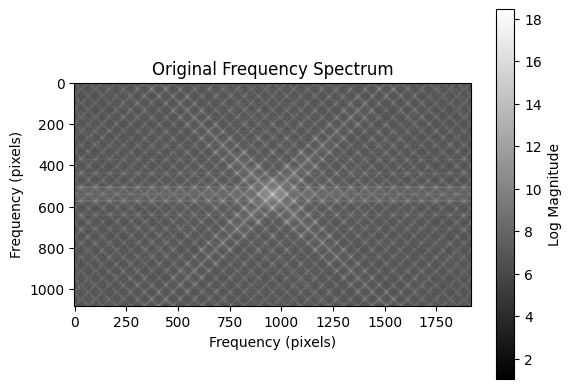

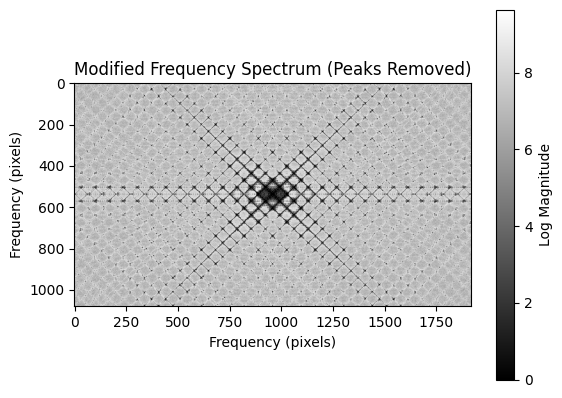

In [59]:
"""
This script loads image data from a pickle file, 
perform Fourier transform (FFT) operations, and modify the frequency spectrum 
by removing periodic components.
"""
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preparation import twod_fft_mag, shift_fft, averager, erase

# Temporary manually inserted periodic_erase function
def periodic_erase(data):
    """
    periodic_erase finds the peaks of the Fourier transform
    by assuming that every value above double the average indicates
    periodic behavior. These values above double the average
    are reduced to zero.
    """
    values = data.values
    ave = averager(values)
    new_data = erase(2 * ave, values)
    return pd.DataFrame(new_data)

# Modified load pickle function
def load_pickle_data(pickle_file_path: str, structure_size: tuple = None):
    try:
        if not os.path.isfile(pickle_file_path):
            raise FileNotFoundError(f"The file '{pickle_file_path}' was not found.")
        
        with open(pickle_file_path, 'rb') as f:
            df = pickle.load(f)

        if df.empty:
            raise ValueError("The loaded DataFrame is empty.")

        print(f"DataFrame shape: {df.shape}")

        # Adjust index and columns based on structure size if provided
        if structure_size:
            rows, cols = structure_size
            if rows * cols != df.size:
                raise ValueError("Structure size does not match the DataFrame size.")
            df.index = list(range(rows))
            df.columns = list(range(cols))
        else:
            df.index = list(range(df.shape[0]))
            df.columns = list(range(df.shape[1]))

        return df
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the pickle file
file_path = '/workspaces/CP1-24-HW6/Images/cube_grid_side_data.pkl'
data = load_pickle_data(file_path)

# Extract the image data
image_data = data.iloc[0, 0]
print(f"Image data type: {type(image_data)}")

# Convert the nested list to a numpy array
image_data = np.array(image_data)

# Convert image data to grayscale by averaging the RGB channels
if image_data.ndim == 3 and image_data.shape[2] == 3:
    gray_image = np.mean(image_data, axis=-1)
else:
    gray_image = image_data

# Perform 2D FFT using twod_fft_mag
fft_result = twod_fft_mag(gray_image)

# Shift the zero-frequency component to the center using shift_fft
shifted_fft_result = shift_fft(pd.DataFrame(fft_result))

# Apply periodic_erase to remove periodic peaks
erased_fft_result = periodic_erase(shifted_fft_result)

# Calculate the frequency spectrum before and after erasing
original_magnitude_spectrum = np.abs(shifted_fft_result)
erased_magnitude_spectrum = np.abs(erased_fft_result)

# Plot the original frequency spectrum
plt.imshow(np.log(original_magnitude_spectrum + 1), cmap='gray') # Log spectrum
plt.colorbar(label='Log Magnitude')
plt.title("Original Frequency Spectrum")
plt.xlabel("Frequency (pixels)")
plt.ylabel("Frequency (pixels)")
plt.show()

# Plot the modified frequency spectrum after erasing periodic components
plt.imshow(np.log(erased_magnitude_spectrum + 1), cmap='gray')
plt.colorbar(label='Log Magnitude')
plt.title("Modified Frequency Spectrum (Peaks Removed)")
plt.xlabel("Frequency (pixels)")
plt.ylabel("Frequency (pixels)")
plt.show()
